In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Autoregressive Models

###  Introduction

Before we start discussing how we can model the distribution $ p(x) $, let us refresh our memory about the core rules of probability theory, namely, the sum rule and the product rule.

Let us introduce two random variables $ x $ and $ y $. Their joint distribution is $ p(x, y) $. The product rule allows us to factorize the joint distribution in two manners:

$$
p(x, y) = p(x|y)p(y) \tag{3.1}
$$

or equivalently:

$$
p(x, y) = p(y|x)p(x) \tag{3.2}
$$

In other words, the joint distribution could be represented as a product of a marginal distribution and a conditional distribution.

The sum rule tells us that if we want to calculate the marginal distribution over one of the variables, we must integrate out (or sum out) the other variable, that is:

$$
p(x) = \sum_y p(x, y) \tag{3.3}
$$

These two rules will play a crucial role in probability theory and statistics and, in particular, in formulating deep generative models.

Now, let us consider a high-dimensional random variable $ x \in \mathcal{X}^D $, where $ \mathcal{X} = \{0, 1, \dots, 255\} $ (e.g., pixel values) or $ \mathcal{X} = \mathbb{R} $. Our goal is to model $ p(x) $. Before we jump into thinking of specific parameterizations, let us first apply the product rule to express the joint distribution in a different manner:

$$
p(x) = \prod_{d=2}^{D} p(x_1) p(x_d | x_{<d}) \tag{3.4}
$$

where $ x_{<d} = [x_1, x_2, \dots, x_{d-1}]^T $. For instance, for $ x = [x_1, x_2, x_3]^T $, we have:

$$
p(x) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2).
$$

The product rule applied multiple times to the joint distribution provides a principled manner of factorizing the joint distribution into many conditional distributions. That’s great news! However, modeling all conditional distributions \( p(x_d | x_{<d}) \) separately is simply infeasible! If we did that, we would obtain \( D \) separate models, and the complexity of each model would grow due to varying conditioning.

A natural question is whether we can do better, and the answer is yes.

##  Autoregressive Models Parameterized by Neural Networks

As mentioned earlier, we aim to model the joint distribution $ p(x) $ using conditional distributions. A potential solution to the issue of using $ D $ separate models is utilizing a single, shared model for the conditional distribution. However, we need to make some assumptions to use such a shared model. In other words, we look for an autoregressive model (ARM). In the next subsection, we outline ARMs parameterized with various neural networks. After all, we are talking about deep generative models, so using a neural network is not surprising, is it?

###  Finite Memory

The first attempt to limit the complexity of a conditional model is to assume a finite memory. For instance, we can assume that each variable is dependent on no more than two other variables, namely:

$$
p(x) = p(x_1)p(x_2 | x_1)p(x_d | x_{d-1}, x_{d-2}) \tag{3.5}
$$

Then, we can use a small neural network, e.g., multilayered perceptrons (MLP), to predict the distribution of $ x_d $. If $ \mathcal{X} = \{0, 1, \dots, 255\} $, the MLP takes $ x_{d-1}, x_{d-2} $ and outputs probabilities for the categorical distribution of $ x_d $, denoted $ \theta_d $.

An example of this approach is depicted in Fig.1.

#### A side note

The MLP could be of the following form:

$$
[x_{d-1}, x_{d-2}] \to \text{Linear}(2, M) \to \text{ReLU} \to \text{Linear}(M, 256) \to \text{softmax} \to \theta_d
$$

where $ M $ denotes the number of hidden units, e.g., $ M = 300 $.

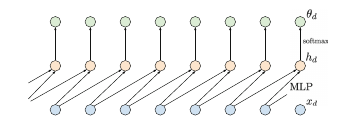
Fig. 3.1 An example of applying a shared MLP depending on two last inputs. Inputs are denoted by blue nodes (bottom), intermediate representations are denoted by orange nodes (middle), and output probabilities are denoted by green nodes (top). Notice that a probability .θ d is not dependent on . x d .
## Fig. 3.1

An example of applying a shared MLP depending on the two last inputs. Inputs are denoted by blue nodes (bottom), intermediate representations are denoted by orange nodes (middle), and output probabilities are denoted by green nodes (top). Notice that a probability $ \theta_d $ is not dependent on $ x_d $. 

It is important to notice that now we use a single, shared MLP to predict probabilities for $ x_d $. Such a model is not only nonlinear, but also its parameterization is convenient due to a relatively small number of weights to be trained. However, the obvious drawback of this approach is a limited memory (i.e., only two last variables in our example). Moreover, it is unclear a priori how many variables we should use in conditioning. In many problems, e.g., image processing, learning long-range statistics is crucial to understand complex patterns in data; therefore, having long-range memory is essential.

##  Long-Range Memory Through RNNs

A possible solution to the problem of short-range memory modeled by an MLP relies on applying a recurrent neural network (RNN) [1, 2]. In other words, we can model the conditional distributions as follows:

$$
p(x_d | x_{<d}) = p(x_d | \text{RNN}(x_{d-1}, h_{d-1})) \tag{3.6}
$$

where $ h_d = \text{RNN}(x_{d-1}, h_{d-1}) $ and $ h_d $ is a hidden context that acts as a memory that allows learning long-range dependencies.

An example of using an RNN is presented in Fig.2. This approach gives a single parameterization; thus, it is efficient and also solves the problem of finite memory. So far, so good!

Unfortunately, RNNs suffer from other issues, namely:
- They are sequential, hence, slow.
- If they are badly conditioned (i.e., the eigenvalues of a weight matrix are larger or smaller than 1), then they suffer from exploding or vanishing gradients, respectively, that hinder learning long-range dependencies.



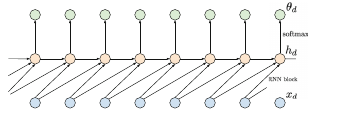

Fig.2 An example of applying an RNN depending on two last inputs. Inputs are denoted by blue nodes (bottom), intermediate representations are denoted by orange nodes (middle), and output probabilities are denoted by green nodes (top). Notice that compared to the approach with a shared MLP, there is an additional dependency between intermediate nodes .h d .
## Fig. 3.1

An example of applying a shared MLP depending on the two last inputs. Inputs are denoted by blue nodes (bottom), intermediate representations are denoted by orange nodes (middle), and output probabilities are denoted by green nodes (top). Notice that a probability \( \theta_d \) is not dependent on \( x_d \). 

It is important to notice that now we use a single, shared MLP to predict probabilities for \( x_d \). Such a model is not only nonlinear, but also its parameterization is convenient due to a relatively small number of weights to be trained. However, the obvious drawback of this approach is a limited memory (i.e., only two last variables in our example). Moreover, it is unclear a priori how many variables we should use in conditioning. In many problems, e.g., image processing, learning long-range statistics is crucial to understand complex patterns in data; therefore, having long-range memory is essential.

## 3.2.2 Long-Range Memory Through RNNs

A possible solution to the problem of short-range memory modeled by an MLP relies on applying a recurrent neural network (RNN) [1, 2]. In other words, we can model the conditional distributions as follows:

\[
p(x_d | x_{<d}) = p(x_d | \text{RNN}(x_{d-1}, h_{d-1})) \tag{3.6}
\]

where \( h_d = \text{RNN}(x_{d-1}, h_{d-1}) \) and \( h_d \) is a hidden context that acts as a memory that allows learning long-range dependencies.

An example of using an RNN is presented in Fig. 3.2. This approach gives a single parameterization; thus, it is efficient and also solves the problem of finite memory. So far, so good!

Unfortunately, RNNs suffer from other issues, namely:
- They are sequential, hence, slow.
- If they are badly conditioned (i.e., the eigenvalues of a weight matrix are larger or smaller than 1), then they suffer from exploding or vanishing gradients, respectively, that hinder learning long-range dependencies.

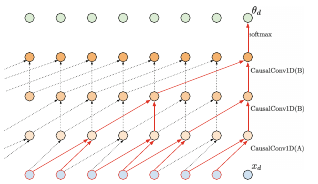

Fig.3 An example of applying causal convolutions. The kernel size is 2, but by applying dilation in higher layers, a much larger input could be processed (red edges); thus, a larger memory is utilized. Notice that the ﬁrst layers must be option A to ensure proper processing.

In [1]:
import torch
import torch.nn as nn

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # If A=True, it will not include the current element; if A=False, it will include the current element
        self.A = A

        # Define the padding based on whether A is True or False
        if self.A:
            padding = (kernel_size - 1) * dilation
        else:
            padding = (kernel_size - 1) * dilation // 2

        # Create a 1D convolutional layer
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=padding, **kwargs)
    
    def forward(self, x):
        # Apply the causal convolution
        if self.A:
            # For A=True, make sure the padding does not include the current input
            x = x[:, :, :-self.conv.padding[0]]  # Cut the last few elements
        return self.conv(x)

# Example of usage
# Assuming the input tensor has a shape [batch_size, channels, sequence_length]
batch_size = 4
in_channels = 1
out_channels = 1
kernel_size = 2
dilation = 2

# Create a random tensor of shape [batch_size, in_channels, sequence_length]
x = torch.randn(batch_size, in_channels, 10)  # sequence_length = 10

# Instantiate the CausalConv1D layer
causal_conv = CausalConv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, dilation=dilation, A=False)

# Forward pass
output = causal_conv(x)
print(output.shape)


torch.Size([4, 1, 10])


In [ ]:
import numpy as np

class CausalConv1D:
    def __init__(self, kernel_size, dilation, A=False):
        """
        - kernel_size: Size of the convolution filter.
        - dilation: Dilation factor for the convolution.
        - A: If True, the convolution does not take the current element (causal filter without current).
        """
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        # Calculate the necessary padding
        if self.A:
            self.padding = (self.kernel_size - 1) * self.dilation
        else:
            self.padding = (self.kernel_size - 1) * self.dilation // 2
    
    def _pad_input(self, x):
        """ Pad the input to ensure causal convolution. """
        return np.pad(x, [(0, self.padding)], mode='constant', constant_values=0)
    
    def _conv(self, x, kernel):
        """ Perform the 1D convolution manually. """
        x_padded = self._pad_input(x)
        output = np.zeros(len(x))
        
        for i in range(len(x)):
            # Define the current window of the sequence to apply the kernel
            start = i * self.dilation
            end = start + self.kernel_size
            
            if self.A:
                end = start + self.kernel_size - 1  # For option A, we exclude the current value
            
            window = x_padded[start:end][::self.dilation]
            output[i] = np.dot(window, kernel)
        
        return output
    
    def forward(self, x, kernel):
        """
        Perform causal convolution forward pass.
        x: Input sequence (1D numpy array)
        kernel: The convolution kernel (filter)
        """
        return self._conv(x, kernel)

# Example usage:
# Define a random input sequence and a kernel
input_sequence = np.array([1, 2, 3, 4, 5])
kernel = np.array([0.2, 0.5, 0.3])  # A simple kernel

# Create a CausalConv1D layer with kernel_size=3, dilation=1, and A=False (to include current element)
causal_conv = CausalConv1D(kernel_size=3, dilation=1, A=False)

# Apply the convolution
output_sequence = causal_conv.forward(input_sequence, kernel)
print("Output Sequence:", output_sequence)


In [3]:
import numpy as np

class CausalConv1D:
    def __init__(self, kernel_size, dilation, A=False):
        """
        - kernel_size: Size of the convolution filter.
        - dilation: Dilation factor for the convolution.
        - A: If True, the convolution does not take the current element (causal filter without current).
        """
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        # Calculate the necessary padding
        if self.A:
            self.padding = (self.kernel_size - 1) * self.dilation
        else:
            self.padding = (self.kernel_size - 1) * self.dilation // 2
    
    def _pad_input(self, x):
        """ Pad the input to ensure causal convolution. """
        return np.pad(x, [(0, self.padding)], mode='constant', constant_values=0)
    
    def _conv(self, x, kernel):
        """ Perform the 1D convolution manually. """
        x_padded = self._pad_input(x)
        output = np.zeros(len(x))
        
        for i in range(len(x)):
            # Define the current window of the sequence to apply the kernel
            start = i * self.dilation
            end = start + self.kernel_size
            
            if self.A:
                end = start + self.kernel_size - 1  # For option A, we exclude the current value
            
            window = x_padded[start:end][::self.dilation]  # Apply dilation
            if len(window) < len(kernel):
                # If the window is smaller than the kernel, we pad the window with zeros
                window = np.pad(window, (0, len(kernel) - len(window)), mode='constant')
            
            output[i] = np.dot(window, kernel)
        
        return output
    
    def forward(self, x, kernel):
        """
        Perform causal convolution forward pass.
        x: Input sequence (1D numpy array)
        kernel: The convolution kernel (filter)
        """
        return self._conv(x, kernel)

# Example usage:
# Define a random input sequence and a kernel
input_sequence = np.array([1, 2, 3, 4, 5])
kernel = np.array([0.2, 0.5, 0.3])  # A simple kernel

# Create a CausalConv1D layer with kernel_size=3, dilation=1, and A=False (to include current element)
causal_conv = CausalConv1D(kernel_size=3, dilation=1, A=False)

# Apply the convolution
output_sequence = causal_conv.forward(input_sequence, kernel)
print("Output Sequence:", output_sequence)


Output Sequence: [2.1 3.1 4.1 3.3 1. ]


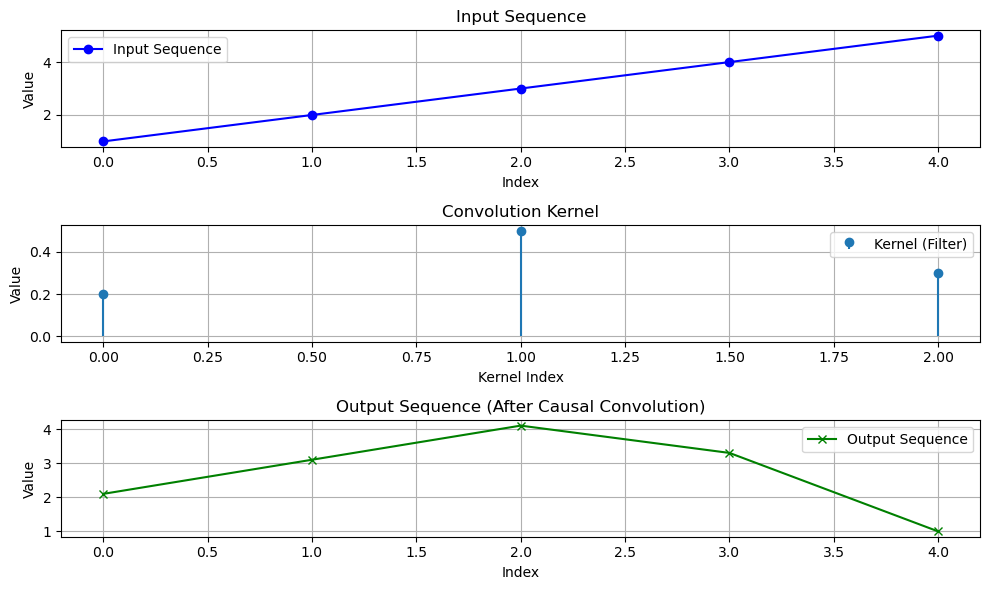

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class CausalConv1D:
    def __init__(self, kernel_size, dilation, A=False):
        """ Initialize the causal convolution layer. """
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        if self.A:
            self.padding = (self.kernel_size - 1) * self.dilation
        else:
            self.padding = (self.kernel_size - 1) * self.dilation // 2
    
    def _pad_input(self, x):
        """ Pad the input to ensure causal convolution. """
        return np.pad(x, [(0, self.padding)], mode='constant', constant_values=0)
    
    def _conv(self, x, kernel):
        """ Perform the 1D convolution manually. """
        x_padded = self._pad_input(x)
        output = np.zeros(len(x))
        
        for i in range(len(x)):
            start = i * self.dilation
            end = start + self.kernel_size
            if self.A:
                end = start + self.kernel_size - 1
            window = x_padded[start:end][::self.dilation]
            if len(window) < len(kernel):
                window = np.pad(window, (0, len(kernel) - len(window)), mode='constant')
            output[i] = np.dot(window, kernel)
        
        return output
    
    def forward(self, x, kernel):
        """ Perform causal convolution forward pass. """
        return self._conv(x, kernel)

# Example usage:
input_sequence = np.array([1, 2, 3, 4, 5])
kernel = np.array([0.2, 0.5, 0.3])  # A simple kernel

# Create a CausalConv1D layer
causal_conv = CausalConv1D(kernel_size=3, dilation=1, A=False)

# Apply the convolution
output_sequence = causal_conv.forward(input_sequence, kernel)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the input sequence
plt.subplot(3, 1, 1)
plt.plot(input_sequence, label='Input Sequence', color='b', marker='o')
plt.title("Input Sequence")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

# Plot the kernel
plt.subplot(3, 1, 2)
plt.stem(kernel, label='Kernel (Filter)', basefmt=" ", use_line_collection=True)
plt.title("Convolution Kernel")
plt.xlabel("Kernel Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

# Plot the output sequence
plt.subplot(3, 1, 3)
plt.plot(output_sequence, label='Output Sequence', color='g', marker='x')
plt.title("Output Sequence (After Causal Convolution)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


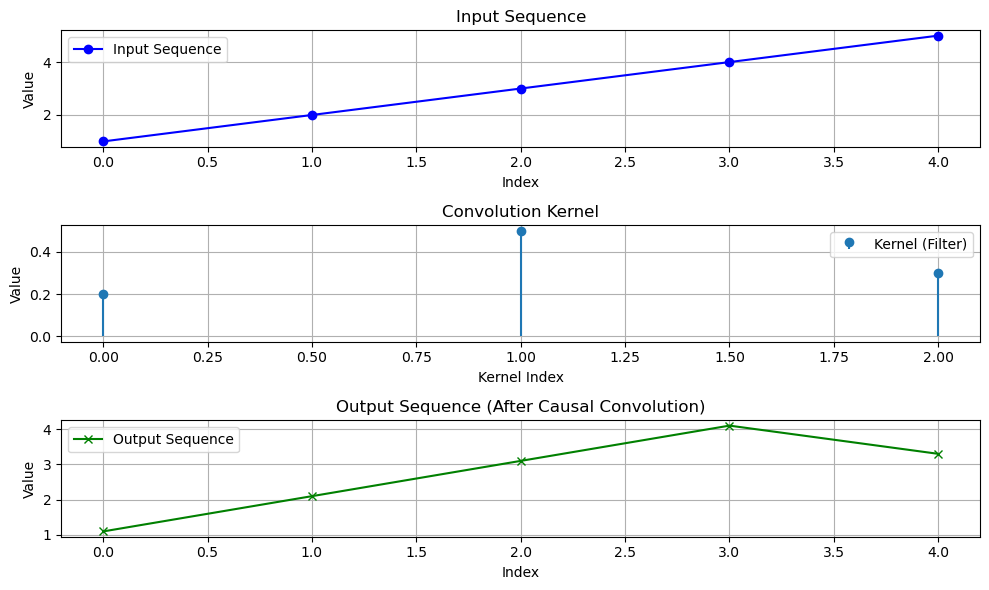

In [5]:
import matplotlib.pyplot as plt

class CausalConv1D:
    def __init__(self, kernel_size, dilation, A=False):
        """ Initialize the causal convolution layer. """
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        if self.A:
            self.padding = (self.kernel_size - 1) * self.dilation
        else:
            self.padding = (self.kernel_size - 1) * self.dilation // 2
    
    def _pad_input(self, x):
        """ Pad the input to ensure causal convolution. """
        return [0] * self.padding + x
    
    def _conv(self, x, kernel):
        """ Perform the 1D convolution manually. """
        x_padded = self._pad_input(x)
        output = [0] * len(x)
        
        for i in range(len(x)):
            start = i * self.dilation
            end = start + self.kernel_size
            if self.A:
                end = start + self.kernel_size - 1
            window = x_padded[start:end:self.dilation]
            if len(window) < len(kernel):
                window.extend([0] * (len(kernel) - len(window)))
            output[i] = sum(w * k for w, k in zip(window, kernel))
        
        return output
    
    def forward(self, x, kernel):
        """ Perform causal convolution forward pass. """
        return self._conv(x, kernel)

# Example usage:
input_sequence = [1, 2, 3, 4, 5]
kernel = [0.2, 0.5, 0.3]  # A simple kernel

# Create a CausalConv1D layer
causal_conv = CausalConv1D(kernel_size=3, dilation=1, A=False)

# Apply the convolution
output_sequence = causal_conv.forward(input_sequence, kernel)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the input sequence
plt.subplot(3, 1, 1)
plt.plot(input_sequence, label='Input Sequence', color='b', marker='o')
plt.title("Input Sequence")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

# Plot the kernel
plt.subplot(3, 1, 2)
plt.stem(kernel, label='Kernel (Filter)', basefmt=" ", use_line_collection=True)
plt.title("Convolution Kernel")
plt.xlabel("Kernel Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

# Plot the output sequence
plt.subplot(3, 1, 3)
plt.plot(output_sequence, label='Output Sequence', color='g', marker='x')
plt.title("Output Sequence (After Causal Convolution)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Causal Convolution 1D

The `CausalConv1D` layers are better suited to modeling sequential data than RNNs. They obtain not only better results (e.g., classification accuracy) but also allow learning long-range dependencies more efficiently than RNNs [8]. Moreover, they do not suffer from exploding/vanishing gradient issues. As a result, they seem to be a perfect parameterization for autoregressive models! Their supremacy has been proven in many cases, including audio processing by WaveNet, a neural network consisting of CausalConv1D layers [9], or image processing by PixelCNN, a model with CausalConv2D components [10].

#### Convolution Formula:

The autoregressive model (ARM) defines the conditional distribution for a sequence of random variables, with the form:

$$ p(x_d | x_{<d}) = \text{Categorical}(x_d | \theta_d(x_{<d})) $$

This conditional is parametrized by the output of the CausalConv1D-based neural network, where:

$$ \prod_{l=1}^{L} [x_d = l] = \theta_{d,l}, $$

with:

$$ \sum_{l=1}^{L} \theta_{d,l} = 1 $$

where $L = 16$ (corresponding to the number of possible values per pixel, assuming a 16-level representation for each pixel).

### Objective Function

As ARM is a likelihood-based model, the goal is to maximize the logarithm of the likelihood function over the dataset. For a given dataset $D = \{x_1, \dots, x_N\}$ with i.i.d. data points, the log-likelihood is:

$$ \ln p(D) = \sum_{n=1}^{N} \ln p(x_n) $$

We decompose the likelihood using the product rule for conditional probabilities:

$$ \ln p(x_n) = \sum_{d=1}^{D} \ln p(x_{n,d} | x_{n,<d}) $$

This results in:

$$ \ln p(x_n) = \sum_{d=1}^{D} \ln \text{Categorical}(x_{n,d} | \theta_d(x_{n,<d})) $$

And finally:

$$ \ln p(x_n) = \sum_{d=1}^{D} \sum_{l=1}^{L} [x_{n,d} = l] \ln \theta_{d,l} $$

This formulation is compact and elegant, and it can be used to maximize the likelihood of the model with respect to its parameters.


### Summing over Dimensions

When parameterizing the conditionals with CausalConv1D layers, we can calculate all $\theta_d$ in one forward pass and then check the pixel value. The goal is to make $\theta_{d,l}$ as close to 1 as possible when $x_d = l$. This allows for efficient and accurate modeling of sequential dependencies in an autoregressive manner.

### ARM Class Implementation

The following is the code for the ARM (Autoregressive Model) class implemented using PyTorch. This class utilizes the CausalConv1D-based network to model long-range dependencies and autoregressive relationships.

```python
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()
        
        # Remember, always credit the author, even if it's you ;)
        print('ARM by JT.')

        # This is a definition of a network. See the next cell.
        self.net = net
        
        # This is how many values a pixel can take.
        self.num_vals = num_vals
        
        # This is the problem dimensionality (the number of pixels).
        self.D = D

    # This function calculates the ARM output
    def f(self, x):
        # First, we apply causal convolutions.
        h = self.net(x.unsqueeze(1))
        
        # In channels, we have the number of values. Therefore, we change the order of dims.
        h = h.permute(0, 2, 1)
        
        # We apply softmax to calculate probabilities.
        p = torch.softmax(h, 2)
        
        return p

    # The forward pass calculates the log-probability of an image.
    def forward(self, x, reduction='avg'):
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either "avg" or "sum".')

    # This function calculates the log-probability (log-categorical).


### Code for Log-Probability and Sampling

```python
# See the full code in the separate file for details.
def log_prob(self, x):
    mu_d = self.f(x)
    log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
    return log_p
# This function implements a sampling procedure.
def sample(self, batch_size):
    # As you can notice, we first initialize a tensor with zeros.
    x_new = torch.zeros((batch_size, self.D))

    # Then, iteratively, we sample a value for a pixel.
    for d in range(self.D):
        p = self.f(x_new)
        x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
        x_new[:, d] = x_new_d[:, 0]
        
    return x_new
# An example of a network. NOTICE: The first layer is A=True, while all other layers are A=False.
# At this point we should know already why :)

M = 256

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True)
)


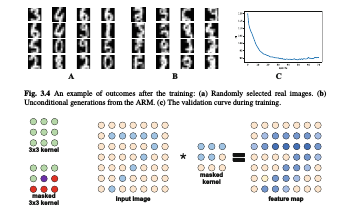
Fig.5 An example of a masked .3 × 3 kernel (i.e., a causal 2D kernel): (left) A diﬀerence between a standard kernel (all weights are used; denoted by green), and a masked kernel (some weights are masked, i.e., not used; in red). For the masked kernel, we denoted the node (pixel) in the middle in violet, because it is either masked (option A) or not (option B). (middle) An example of an image (light orange nodes, zeros; light blue nodes, ones) and a masked kernel (option A). (right) The result of applying the masked kernel to the image (with padding equal to 1).
### Fig. 3.4: Example of Training Outcomes

- **(a)**: Randomly selected real images.
- **(b)**: Unconditional generations from the ARM.
- **(c)**: The validation curve during training.

---

### Fig. 3.5: Masked 3×3 Kernel Example

#### Description:
- **Left**: 
    - Standard kernel: All weights are used (denoted in **green**).
    - Masked kernel: Some weights are masked (not used, denoted in **red**). 
    - The middle node (pixel) is highlighted in **violet**:
        - It is either masked (Option A) or not masked (Option B).

- **Middle**:
    - Example of an image with:
        - **Light orange nodes**: Represent zeros.
        - **Light blue nodes**: Represent ones.
    - A masked kernel with **Option A** applied.

- **Right**:
    - Result of applying the masked kernel to the image with padding set to 1.

---

### Moving to 2D Causal Convolutions

#### Challenges with 1D Causal Convolutions:
- While effective for sequences, 1D causal convolutions are typically insufficient for images due to their spatial dependencies.

#### Proposal in [10]:
- **CausalConv2D**:
    - The kernel is designed to avoid "looking into the future" pixels along both the **x-axis** and **y-axis**.

- **Key Characteristics**:
    - The first layer uses **Option A** (skipping the middle pixel).
    - Subsequent layers can use **Option B**.

#### Fig. 3.6: Numerical Example
- Illustrates the same concept as Fig. 3.5 but using numerical values.

---

### Further Improvements in [12]

#### Vertical and Horizontal Convolutions:
- The authors propose a **block** consisting of:
    - **Vertical convolutional layers**.
    - **Horizontal convolutional layers**.

#### Gated Non-Linearity:
- They introduce a non-linearity function defined as:
$$
h = \tanh(Wx) \odot \sigma(Vx),
$$
where:
- \(Wx\): Weighted input for the **tanh** activation.
- \(Vx\): Weighted input for the **sigmoid** activation.
- \(\odot\): Element-wise multiplication.

---

### Summary
- **CausalConv1D** and **CausalConv2D** are powerful tools for modeling sequential and image data.
- Masked kernels ensure autoregressive properties by restricting dependencies.
- Further improvements, like combining vertical and horizontal layers with gated non-linearities, enhance flexibility and performance.

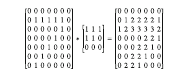

Fig.6 The same example as in Fig5 but with numeric values.

In [ ]:
### Fig. 3.6: Numerical Example of Masked Kernel Application

This figure demonstrates the same concept as Fig. 3.5 but using numerical values. For detailed explanations, refer to Figure 2 in [12].

---

### Further Improvements on ARMs for Images

#### Discretized Logistic Distribution:
- Instead of using a categorical distribution for modeling pixel values, the authors in [13] propose:
  - **Discretized logistic distribution**.
  - **Mixture of discretized logistic distributions** to enhance flexibility in ARMs.

#### Impact of Causal Convolutions:
- Causal convolutions enabled state-of-the-art generation and density estimation for deep generative models.

---

### Notable Directions and Applications of ARMs

1. **Alternative Pixel Ordering**:
    - Instead of left-to-right, a "zig-zag" pattern allows dependencies on both left and above pixels [14].

2. **Combination with Other Models**:
    - ARMs can model priors in (Variational) Auto-Encoders [15].

3. **Modeling Videos**:
    - ARMs naturally factorize sequential video data, making them a perfect fit for this domain [16].

4. **Addressing Lack of Latent Representation**:
    - A PixelCNN-based decoder integrated with a variational auto-encoder provides latent representation [17].

5. **Architectural Advancements**:
    - Proposals for new components or architectures focus on:
        - Speeding up sampling, e.g., predictive sampling [11, 18].
        - Using other similarity metrics like the **Wasserstein distance**, applied in quantile regression [19].

6. **Transformers as an Alternative**:
    - Transformers replace causal convolutions with self-attention layers, providing a powerful generative modeling approach [20].

7. **Multi-Scale ARMs**:
    - Scale high-quality images logarithmically rather than quadratically:
        - Local independence assumptions [21].
        - Spatial partitioning [22].
    - These techniques lower memory requirements but do not significantly improve sampling speed.

---

### Summary
The advancements in ARMs, from their application to images to architectural innovations, highlight their versatility and potential. While challenges like sampling speed persist, ongoing research offers promising solutions.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, A=True):
        """
        A causal convolution layer.
        
        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            kernel_size: Size of the convolution kernel.
            dilation: Dilation factor for the kernel.
            A: Option A (True) or B (False) for masking.
        """
        super(CausalConv1D, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.padding = (kernel_size - 1) * dilation if not A else (kernel_size - 1) * dilation + 1
        self.conv1d = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation,
            padding=0,
            bias=True
        )

    def forward(self, x):
        # Left-padding to ensure causality
        x = F.pad(x, (self.padding, 0))
        return self.conv1d(x)


class ARM(nn.Module):
    def __init__(self, net, num_vals=256, D=2):
        """
        Autoregressive Model.
        
        Args:
            net: The neural network defining the autoregressive model.
            num_vals: Number of possible values per pixel.
            D: Dimensionality of the input (number of pixels).
        """
        super(ARM, self).__init__()
        self.net = net
        self.num_vals = num_vals
        self.D = D

    def f(self, x):
        """
        Compute probabilities for each pixel value.
        """
        h = self.net(x.unsqueeze(1))  # Input is (batch_size, 1, D)
        h = h.permute(0, 2, 1)  # Rearrange dimensions to (batch_size, D, num_vals)
        p = F.softmax(h, dim=2)  # Apply softmax to obtain probabilities
        return p

    def log_prob(self, x):
        """
        Calculate log probabilities for the input data.
        """
        probs = self.f(x)
        one_hot_x = F.one_hot(x.long(), num_classes=self.num_vals).float()  # Convert input to one-hot encoding
        log_probs = torch.sum(torch.log(torch.sum(probs * one_hot_x, dim=2)), dim=1)  # Log-sum over classes
        return log_probs

    def forward(self, x, reduction="avg"):
        """
        Compute negative log-likelihood for the input data.
        """
        log_p = self.log_prob(x)
        if reduction == "avg":
            return -log_p.mean()
        elif reduction == "sum":
            return -log_p.sum()
        else:
            raise ValueError("Reduction must be 'avg' or 'sum'.")

    def sample(self, batch_size):
        """
        Sample new data based on learned probabilities.
        """
        x_new = torch.zeros((batch_size, self.D), device=next(self.parameters()).device)
        for d in range(self.D):
            probs = self.f(x_new)
            sampled_vals = torch.multinomial(probs[:, d, :], num_samples=1)
            x_new[:, d] = sampled_vals[:, 0]
        return x_new


# Define a simple network using CausalConv1D layers
kernel_size = 3
num_vals = 256
D = 16  # Number of pixels
hidden_dim = 128

net = nn.Sequential(
    CausalConv1D(1, hidden_dim, kernel_size, A=True),
    nn.LeakyReLU(),
    CausalConv1D(hidden_dim, hidden_dim, kernel_size, A=False),
    nn.LeakyReLU(),
    CausalConv1D(hidden_dim, hidden_dim, kernel_size, A=False),
    nn.LeakyReLU(),
    CausalConv1D(hidden_dim, num_vals, kernel_size, A=False)
)

# Instantiate the ARM model
model = ARM(net, num_vals=num_vals, D=D)

# Example usage
batch_size = 4
x = torch.randint(0, num_vals, (batch_size, D)).float()  # Random input data
loss = model(x, reduction="avg")
print("Loss:", loss.item())

# Sampling
samples = model.sample(batch_size)
print("Generated Samples:\n", samples)
